##Download and prepare datasets

Device: cuda:0
EuroSAT_RGB dataset found
train dataset found
5760
5760
26880


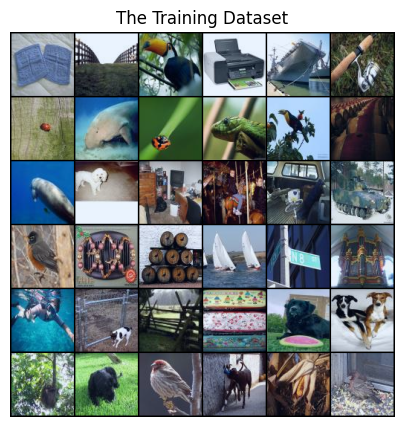

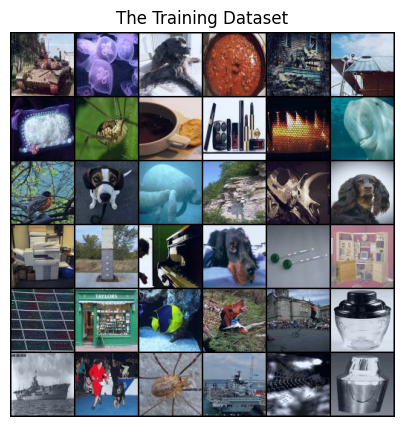

In [4]:

import argparse
import os
import random
import requests, zipfile, sys
import tarfile

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.utils as utils
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import time
from PIL import Image

#enabe gpu if available with cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# check data exists
eurosat_path = "data/EuroSAT_RGB"
try: 
    if os.path.exists(eurosat_path):
        print("EuroSAT_RGB dataset found")
    elif os.path.exists(eurosat_path + ".zip"):
        print("train.tar dataset found, unzipping...")
        with zipfile.ZipFile(eurosat_path + ".zip", "r") as zf:
            print("Opened zipfile")
            zf.extractall("data/")
            print("EuroSAT_RGB.zip extracted")
except FileNotFoundError:
    print("The file data/EuroSAT_RGB was not found")

train_tar = "data/train"
try: 
    if os.path.exists(train_tar):
        print("train dataset found")
    elif os.path.exists(train_tar + ".tar"):
        print("train.tar dataset found, unzipping...")
        with tarfile.open(train_tar + ".tar", "r") as tf:
            print("Opened tarfile")
            tf.extractall(path="data/")
            print("train.tar extracted")
except FileNotFoundError:
    print("train data was not found")


#Download train.tar -file from miniImageNet datset
train_tar = "data/train"

# Image Size
tar_image_size = 84
eurosat_image_size = 64

# Load the dataset
transform = transforms.Compose([
    transforms.Resize((tar_image_size, tar_image_size)),  # Resize to a common size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(train_tar, transform=transform)

# Splitting the dataset into train, val, and test
data_len = len(dataset)
test = int(data_len  * 0.15)
valid = test
train = len(dataset) - test * 2
print(test)
print(valid)
print(train)


train_dataset, val_dataset, test_dataset = random_split(dataset, [train, valid, test])

# Batch size during training
batch_size = 128
num_workers = 1

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('The Training Dataset')
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:36], padding=2, normalize=True, nrow=6).cpu(),(1,2,0)))
plt.show()

#Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.title('The Training Dataset')
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:36], padding=2, normalize=True, nrow=6).cpu(),(1,2,0)))
plt.show()



#

## Pretrain a model

In [5]:
#hyperparameters

# Learning rate for optimizers
lr = 0.0002

# Number of training epochs
num_epochs = 30

# Define transformations

#model selection

#training

#evaluation

##Fine-tuning with EuroSAT dataset

In [6]:
#select data

#fine tune

#tesing

##Model comparison and optimization

##Evaluation on additional dataset (bonus tasks)